In [20]:
import os
import io
import cv2
import h5py
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import random
import ecg_plot

In [4]:
import numpy as np
from scipy.stats import norm
import fs as fs
import wfdb
from matplotlib import pyplot as plt
from scipy.signal import resample
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import os
import pandas as pd
from ecgdetectors import Detectors
from wfdb.io import annotation
import pywt
import ast

In [24]:
path = r'D:/ECGData/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

rootdir = r'D:\ECGData\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\00000'
name = '00080_lr'

In [28]:
rootdir = r'D:\ECGData\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records500\00000'
name = '00080_hr'

In [5]:
def process_ecg_record_nonlinear(record):
    """
    Process a 12-lead ECG record: read the voltage data, determine the range, and standardize the data using a non-linear scaling.

    Args:
    - record: wfdb Record object containing the 12-lead ECG data.

    Returns:
    - standardized_leads (dict): Dictionary with lead names as keys and standardized data as values.
    """
    # Extract data and lead names
    data = record.p_signal
    lead_names = record.sig_name

    voltage_ranges = {}
    for i, lead in enumerate(lead_names):
        min_voltage = np.min(data[:, i])
        max_voltage = np.max(data[:, i])
        voltage_ranges[lead] = (max_voltage - min_voltage)

    # Find the mean and standard deviation of the voltage ranges
    mean_range = np.mean(list(voltage_ranges.values()))
    std_range = np.std(list(voltage_ranges.values()))

    standardized_leads = {}

    for i, lead in enumerate(lead_names):
        # Determine the scaling factor for each lead based on the normal distribution
        z_score = (voltage_ranges[lead] - mean_range) / std_range
        scaling_factor = norm.cdf(z_score)

        # Normalize the data to (-scaling_factor, scaling_factor)
        standardized_data = 2 * scaling_factor * (data[:, i] - np.min(data[:, i])) / (
                np.max(data[:, i]) - np.min(data[:, i])) - scaling_factor

        # Store results in dictionaries
        standardized_leads[lead] = standardized_data

    return standardized_leads

In [25]:
segments_starts = [0, 250, 500, 750]

In [30]:
oneRecord = wfdb.rdrecord(os.path.join(rootdir,name), sampfrom=0, sampto=5000)

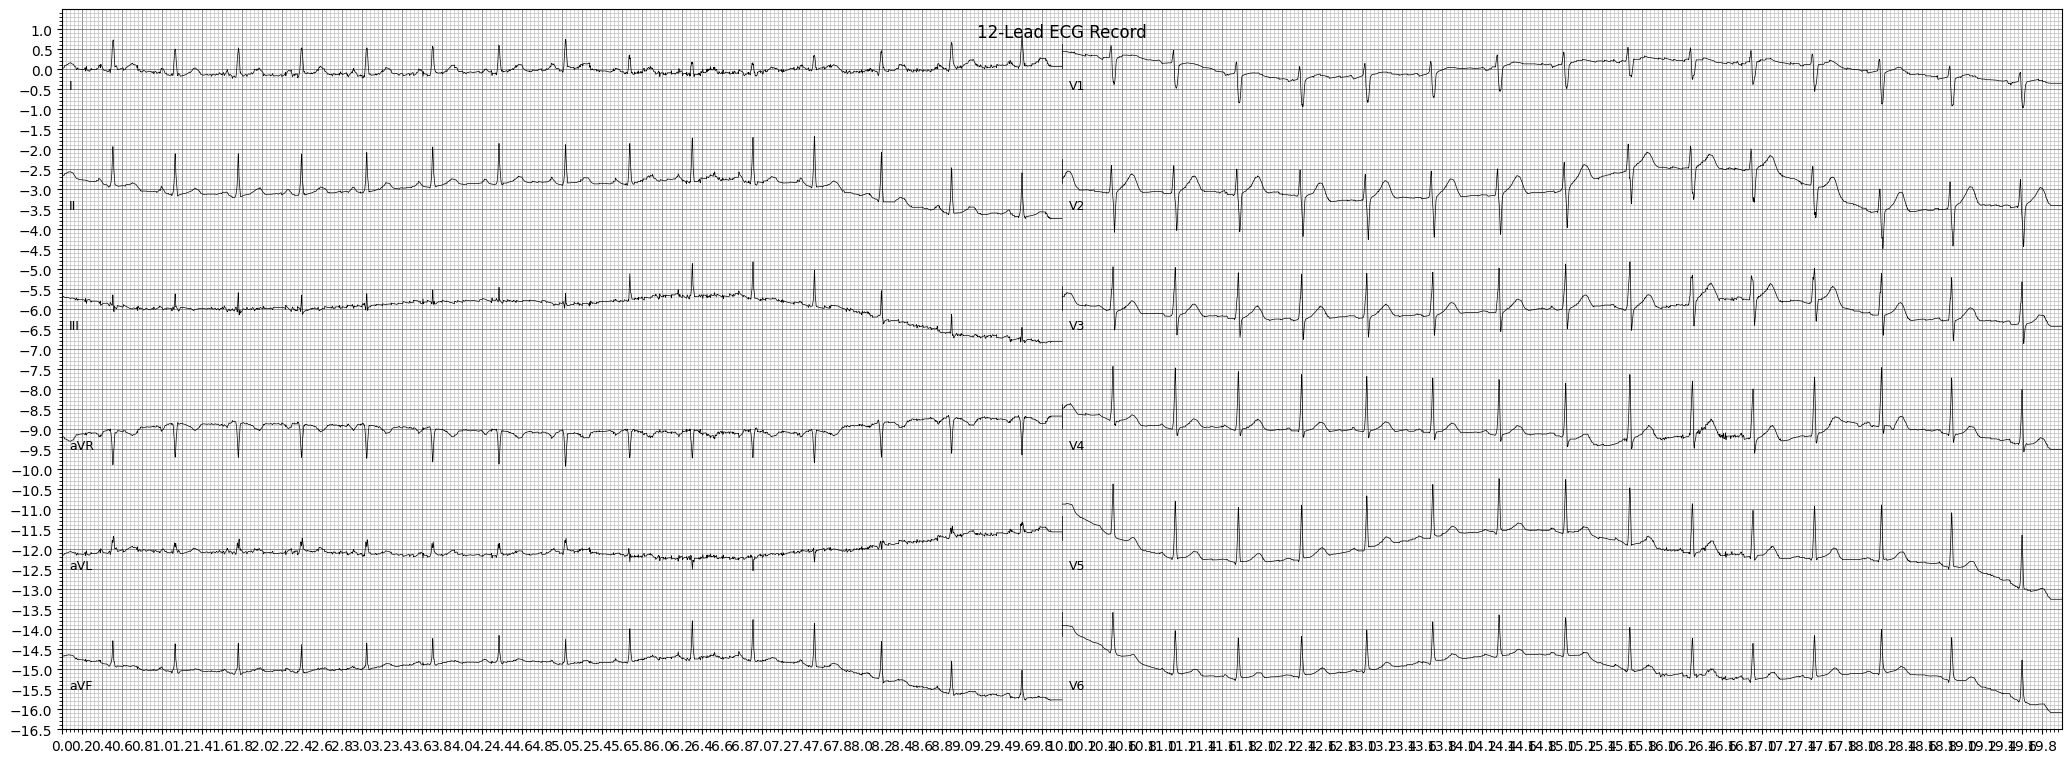

In [33]:
# 这里我们假设ECG记录是12导联的
ecg_signals = oneRecord.p_signal.transpose()  # 转置以匹配ecg_plot的输入格式

# 绘制12导联的ECG图像
# 注意：ecg_plot.plot() 默认设置可能不适用于所有12导联，但基本足够用于一般情况
# ecg_plot.plot(ecg_signals, sample_rate=oneRecord.fs, title='12-Lead ECG Record', columns=3, rows=4)
ecg_plot.plot(ecg_signals, sample_rate=oneRecord.fs, title='12-Lead ECG Record',style='bw')


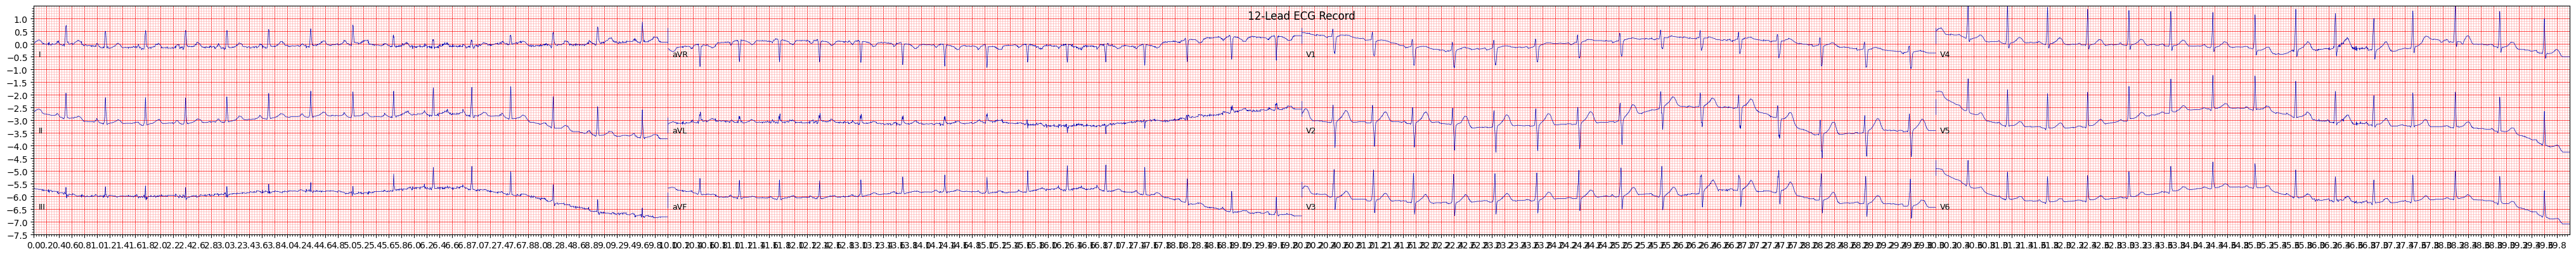

In [32]:
# 这里我们假设ECG记录是12导联的
ecg_signals = oneRecord.p_signal.transpose()  # 转置以匹配ecg_plot的输入格式

# 绘制12导联的ECG图像
# 注意：ecg_plot.plot() 默认设置可能不适用于所有12导联，但基本足够用于一般情况
# ecg_plot.plot(ecg_signals, sample_rate=oneRecord.fs, title='12-Lead ECG Record', columns=3, rows=4)
ecg_plot.plot(ecg_signals, sample_rate=oneRecord.fs, title='12-Lead ECG Record',columns=4)


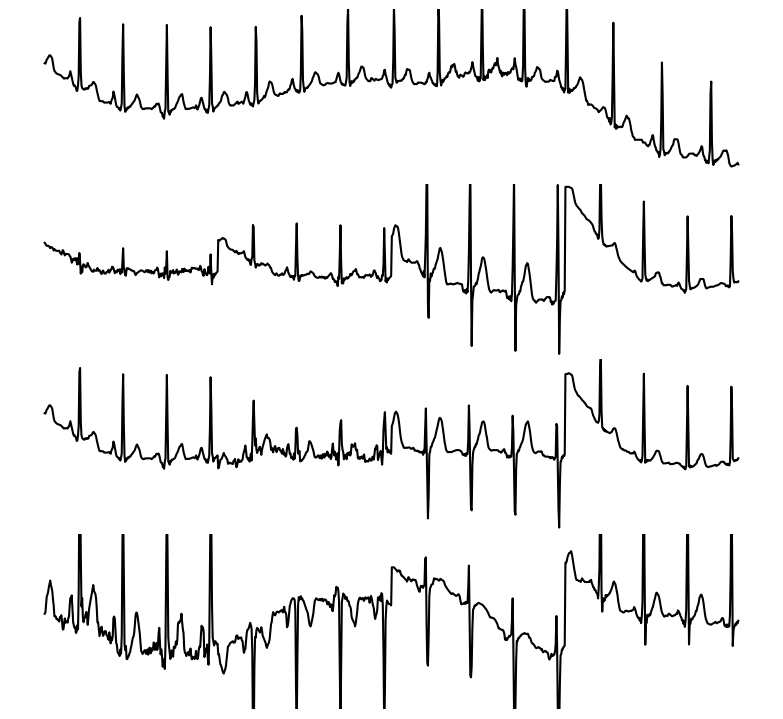

NameError: name 'buf' is not defined

In [18]:
generate_ecg_image(oneRecord,segments_starts[0])

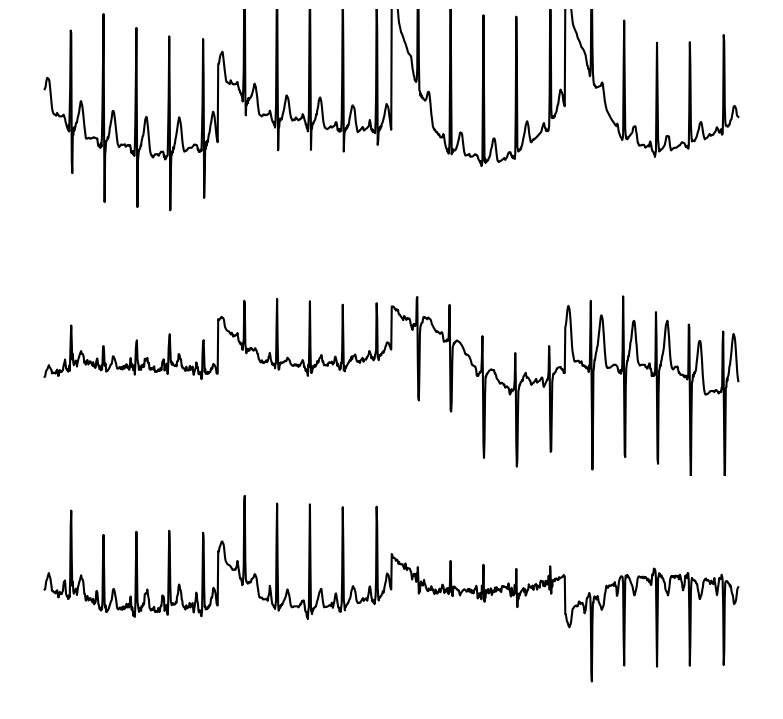

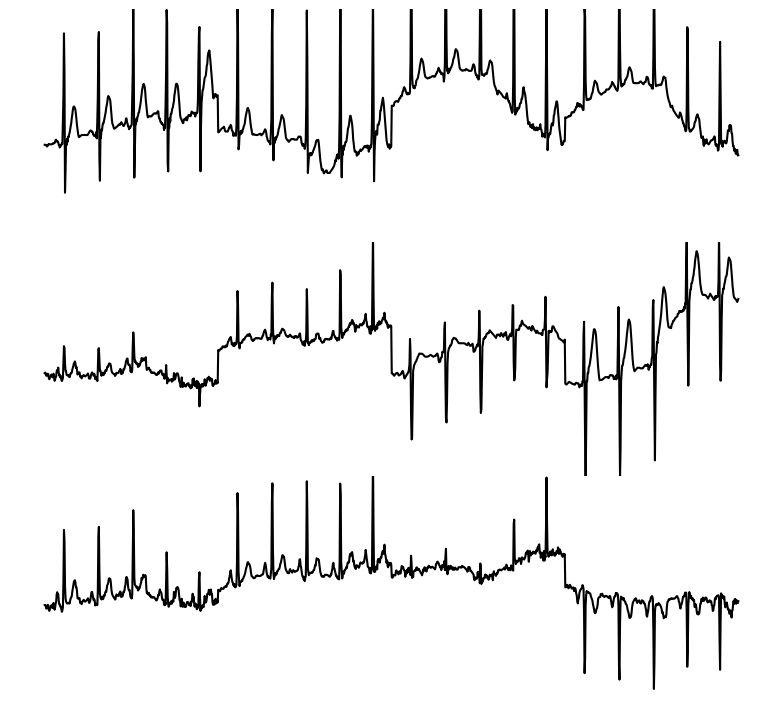

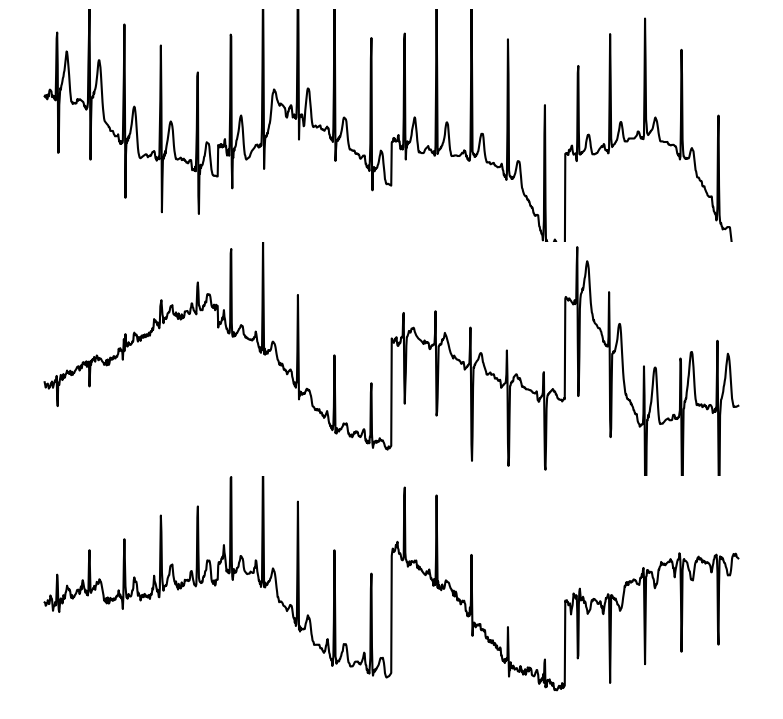

In [6]:
recordsOfOnePatient = []
for i in [0, 333, 666]:
    recordsOfOnePatient.append(wfdb.rdrecord(os.path.join(rootdir, name), sampfrom=i, sampto=333+i))

for record in recordsOfOnePatient:
    standardized_leads = process_ecg_record_nonlinear(record)


    # 从 record 中提取数据并为每个导联创建一个字典条目
    twelve_leads = {f'Lead{i + 1}': record.p_signal[:, i] for i in range(12)}

    # 创建一个更小的画布
    fig, axs = plt.subplots(3, 1, figsize=(7, 7), sharex=True, sharey=True)

    # 遍历十二导联数据并绘制
    for i in range(3):
        combined_x_data = []
        combined_y_data = []
        for j in range(4):
            x_data = list(range(len(twelve_leads[list(twelve_leads.keys())[i * 4 + j]])))
            y_data = twelve_leads[list(twelve_leads.keys())[i * 4 + j]]
            if j > 0:
                offset = combined_x_data[-1] + 1
                x_data = [x + offset for x in x_data]
                # axs[i].axvline(x=offset, color='black', linestyle='--')
            combined_x_data.extend(x_data)
            combined_y_data.extend(y_data)

        axs[i].plot(combined_x_data, combined_y_data, color='black')
        axs[i].axis('off')
        axs[i].set_ylim([-1, 1])
        axs[i].set_position([-0.045, i * 1 / 3, 1.09, 1 / 3])
        # 在子图之间添加分隔虚线
        # if i < 2:  # 不需要在最后一个子图下方添加
        #     axs[i].axhline(y=1, color='black', linestyle='--')  # 在子图的顶部添加虚线

    # 保存为图片文件
    output_path = os.path.join(path, f"{name}_ecg_image.png")
    plt.savefig(output_path, dpi=32)
    plt.show()
    plt.close()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import io

def generate_ecg_image(record, segment_start):
    lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    twelve_leads_full = {lead_names[i]: record.p_signal[:, i] for i in range(12)}

    # Standardizing each lead separately
    standardized_twelve_leads = {
        lead: (twelve_leads_full[lead] - np.mean(twelve_leads_full[lead])) / np.std(twelve_leads_full[lead]) for lead in lead_names}

    segment_end = segment_start + 250
    segments = {lead: signal[segment_start:segment_end] for lead, signal in standardized_twelve_leads.items()}

    fig, axs = plt.subplots(4, 1, figsize=(7, 7))

    for i in range(3):
        combined_x_data = []
        combined_y_data = []
        for j in range(4):
            lead = lead_names[(j * 3) + i]
            x_data = list(range(len(combined_x_data), len(combined_x_data) + 250))
            y_data = segments[lead]
            combined_x_data.extend(x_data)
            combined_y_data.extend(y_data)

        axs[i].plot(combined_x_data, combined_y_data, color='black')
        axs[i].axis('off')
        axs[i].set_ylim([-3, 3])
        axs[i].set_position([-0.045, i * 1 / 4, 1.09, 1 / 4])

    # 修改第四行以固定显示II型导联的数据
    x_data_full = list(range(0, 1000))
    y_data_full = standardized_twelve_leads['II'][0:1000]  # 固定使用II型导联
    axs[3].plot(x_data_full, y_data_full, color='black')
    axs[3].axis('off')
    axs[3].set_ylim([-3, 3])
    axs[3].set_position([-0.045, 3 * 1 / 4, 1.09, 1 / 4])
    
    plt.show()

#     buf = io.BytesIO()
#     plt.savefig(buf, format='png', dpi=32)
#     buf.seek(0)
    plt.close()

    img = cv2.imdecode(np.frombuffer(buf.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
    return img


In [2]:
class ECGDataLoader:
    def __init__(self, data_path):
        self.path = data_path
        self.scp_statements = {
            'NDT': 'STTC', 'NORM': 'NORM', 'NST_': 'STTC', 'DIG': 'STTC', 'LNGQT': 'STTC',
            'IMI': 'MI', 'ASMI': 'MI', 'LVH': 'HYP', 'LAFB': 'CD', 'ISC_': 'STTC',
            'IRBBB': 'CD', '1AVB': 'CD', 'IVCD': 'CD', 'ISCAL': 'STTC', 'CRBBB': 'CD',
            'CLBBB': 'CD', 'ILMI': 'MI', 'LAO/LAE': 'HYP', 'AMI': 'MI', 'ALMI': 'MI',
            'ISCIN': 'STTC', 'INJAS': 'MI', 'LMI': 'MI', 'ISCIL': 'STTC', 'LPFB': 'CD',
            'ISCAS': 'STTC', 'INJAL': 'MI', 'ISCLA': 'STTC', 'RVH': 'HYP', 'ANEUR': 'STTC',
            'RAO/RAE': 'HYP', 'EL': 'STTC', 'WPW': 'CD', 'ILBBB': 'CD', 'IPLMI': 'MI',
            'ISCAN': 'STTC', 'IPMI': 'MI', 'SEHYP': 'HYP', 'INJIN': 'MI', 'INJLA': 'MI',
            'PMI': 'MI', '3AVB': 'CD', 'INJIL': 'MI', '2AVB': 'CD'
        }

    def load_single_record(self, filename, sampfrom, sampto):
        return wfdb.rdrecord(os.path.join(self.path, filename), sampfrom=sampfrom, sampto=sampto)

    def load_Y_data(self):
        Y = pd.read_csv(os.path.join(self.path, 'ptbxl_database.csv'), index_col='ecg_id')
        return Y

In [10]:
class ECGImageProcessor:
    def __init__(self, scp_mapping, superclass):
        self.scp_mapping = scp_mapping
        self.superclass = superclass
        self.lead_order_for_fourth_row = list(range(0, 12))

    def map_to_superclass(self, scp_code, threshold=50.0):
        """Convert the given scp_code into its superclass by first finding the maximum value for each superclass
        and then binarizing the result based on a specified threshold.
        Values >= threshold are set to 1, indicating significant presence, while values < threshold are set to 0, indicating absence or insignificance.
        """

        # Initialize the superclass_values dictionary with desired classes and zero values
        superclass_dict = {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 0, 'STTC': 0}

        # First pass: Iterate through the scp_code dictionary and update to the maximum value
        for key, value in scp_code.items():
            superclass = self.scp_mapping.get(key)
            if superclass:
                # Only update if the new value is greater than the current value
                if value > superclass_dict[superclass]:
                    superclass_dict[superclass] = value

        # Second pass: Binarize the superclass_dict based on the specified threshold
        for key in superclass_dict:
            superclass_dict[key] = 1 if superclass_dict[key] >= threshold else 0

        return superclass_dict

    def generate_ecg_image(self, record, segment_start):
        lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        twelve_leads_full = {lead_names[i]: record.p_signal[:, i] for i in range(12)}

        # Standardizing each lead separately
        standardized_twelve_leads = {
            lead: (twelve_leads_full[lead] - np.mean(twelve_leads_full[lead])) / np.std(twelve_leads_full[lead]) for lead in lead_names}


        segment_end = segment_start + 250
        # Step 2: 从每个导联中提取一个长度为250的段
        segments = {lead: signal[segment_start:segment_end] for lead, signal in standardized_twelve_leads.items()}

        fig, axs = plt.subplots(4, 1, figsize=(7, 7))

        # Step 3: 使用这些数据段进行绘制
        for i in range(3):
            combined_x_data = []
            combined_y_data = []
            for j in range(4):
                lead = lead_names[(j * 3) + i]  # Directly use the lead_names list
                x_data = list(range(len(combined_x_data), len(combined_x_data) + 250))
                y_data = segments[lead]
                combined_x_data.extend(x_data)
                combined_y_data.extend(y_data)

            axs[i].plot(combined_x_data, combined_y_data, color='black')
            axs[i].axis('off')
            axs[i].set_ylim([-3, 3])
            axs[i].set_position([-0.045, i * 1 / 4, 1.09, 1 / 4])


        lead_idx = self.lead_order_for_fourth_row.pop(0)

        if not self.lead_order_for_fourth_row:
            self.lead_order_for_fourth_row = list(range(0, 12))
        x_data_full = list(range(0,1000))
        y_data_full = standardized_twelve_leads[lead_names[lead_idx]][0:1000]
        axs[3].plot(x_data_full, y_data_full, color='black')
        axs[3].axis('off')
        axs[3].set_ylim([-3, 3])
        axs[3].set_position([-0.045, 3 * 1 / 4, 1.09, 1 / 4])

        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=32)
        buf.seek(0)
        plt.close()

        #No special treatment, no standardization for lead voltage range
        img = cv2.imdecode(np.frombuffer(buf.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
        return img


    def save_ecg_image_to_hdf5(self, img, hdf5_file,  superclass_values, filename, segment_idx):
        # 用filename和segment_idx作为组名
        group_name = f"{filename}_{segment_idx}"
        if group_name not in hdf5_file:
            group = hdf5_file.create_group(group_name)
        else:
            group = hdf5_file[group_name]

        # 检查"image"数据集是否已经存在
        if "image" not in group:
            group.create_dataset("image", data=img)

        # 将Soft Labels存储到该组中
        for label_name, value in superclass_values.items():
            group.attrs[label_name] = value

    def process_and_save_images(self, Y, save_path, display_num=5, seed=42):
        # Set the random seed for reproducibility
        random.seed(seed)
        np.random.seed(seed)  # If you're using numpy in other parts of your code

        # Use the keys from the superclass dictionary to initialize image_counter
        image_counter = {partition: {superclass: 0 for superclass in self.superclass.keys()}
                         for partition in ['train', 'val', 'test']}

        # Create or open HDF5 files for each partition
        hdf5_files = {
            'train': h5py.File(os.path.join(save_path, 'train.h5'), 'a'),
            'val': h5py.File(os.path.join(save_path, 'val.h5'), 'a'),
            'test': h5py.File(os.path.join(save_path, 'test.h5'), 'a')
        }

        segments_starts = [0, 250, 500, 750]
        display_indices = random.sample(range(len(Y)), min(len(Y), display_num))  # Determine random indices to display

        for idx, (index, row) in enumerate(Y.iterrows()):  # Ensure proper enumeration
            filename = row['filename_lr']
            superclass_values = row['superclass_values']

            # Skip the row if all superclass_values are zero
            if all(value == 0 for value in superclass_values.values()):
                continue  # Skip processing and saving this sample

            # Load the entire 10-second record
            full_record = data_loader.load_single_record(filename, 0, 1000)

            # Determine the dataset partition based on the strat_fold value
            if row['strat_fold'] in [1, 2, 3, 4, 5, 6, 7, 8]:
                partition = 'train'
            elif row['strat_fold'] == 9:
                partition = 'val'
            else:
                partition = 'test'

            for segment_start in segments_starts:
                # Generate the image for the segment
                img = self.generate_ecg_image(full_record, segment_start)
                segment_idx = segments_starts.index(segment_start)

                # Save the generated image to the HDF5 file
                self.save_ecg_image_to_hdf5(img, hdf5_files[partition], superclass_values, filename, segment_idx)

                # Update the image counter for the respective partition and superclass
                for superclass in self.superclass.keys():  # Use superclass keys from initialization
                    if superclass_values.get(superclass, 0) > 0:
                        image_counter[partition][superclass] += 1

                # Randomly display the image
                if idx in display_indices:
                    plt.figure(figsize=(10, 2))
                    plt.imshow(img, cmap='gray')
                    plt.title(f"Sample {idx}: {filename}")
                    plt.axis('off')
                    plt.show()

        # Close the HDF5 files
        for hdf5_file in hdf5_files.values():
            hdf5_file.close()

        return image_counter



In [4]:
path = r'D:/ECGData/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
superclass = {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 0, 'STTC': 0}


data_loader = ECGDataLoader(path)

In [5]:
diagnostic_mapping = data_loader.scp_statements
Y = data_loader.load_Y_data()

In [6]:
print(Y.shape)

(21799, 27)


In [7]:
print(Y['scp_codes'])

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object


In [8]:
Y['scp_codes_dict'] = Y['scp_codes'].apply(eval)

In [11]:
processor = ECGImageProcessor(diagnostic_mapping, superclass)
Y['superclass_values'] = Y['scp_codes_dict'].apply(lambda x: processor.map_to_superclass(x))

In [12]:
print(Y['superclass_values'])

ecg_id
1        {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 1, 'STTC'...
2        {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 1, 'STTC'...
3        {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 1, 'STTC'...
4        {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 1, 'STTC'...
5        {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 1, 'STTC'...
                               ...                        
21833    {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 0, 'STTC'...
21834    {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 1, 'STTC'...
21835    {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 0, 'STTC'...
21836    {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 1, 'STTC'...
21837    {'CD': 0, 'HYP': 0, 'MI': 0, 'NORM': 1, 'STTC'...
Name: superclass_values, Length: 21799, dtype: object


In [13]:
Y = Y.dropna(subset=['superclass_values'])

In [14]:
print(Y.shape)

(21799, 29)


In [15]:
# 转换 'superclass_values' 字典为 DataFrame
superclass_df_filtered = Y['superclass_values'].apply(pd.Series)

# 计算不为零的次数
non_zero_counts_filtered = superclass_df_filtered.apply(lambda x: (x > 0).sum())

# 打印结果
print(non_zero_counts_filtered)

CD      4891
HYP     2258
MI      4134
NORM    9438
STTC    5078
dtype: int64


In [ ]:
# 转换 'superclass_values' 字典为 DataFrame
superclass_df_filtered = Y_filtered['superclass_values'].apply(pd.Series)

# 计算不为零的次数
non_zero_counts_filtered = superclass_df_filtered.apply(lambda x: (x > 0).sum())

# 打印结果
print(non_zero_counts_filtered)


In [ ]:
import pandas as pd

# 假设 Y 已经是你的 DataFrame，并且 'superclass_values' 列已经正确填充

# 转换 'superclass_values' 字典为 DataFrame
superclass_df_filtered = Y['superclass_values'].apply(pd.Series)

# 计算每行的非零值数量
non_zero_per_row = superclass_df_filtered.apply(lambda x: (x > 0).sum(), axis=1)

# 统计每个非零值数量的出现次数
non_zero_distribution = non_zero_per_row.value_counts().sort_index()  # 使用 sort_index() 保证结果按非零值的数量排序

# 打印结果
print(non_zero_distribution)


In [ ]:
import pandas as pd

# 假设 Y 已经是你的 DataFrame，并且 'superclass_values' 列已经正确填充

# 转换 'superclass_values' 字典为 DataFrame
superclass_df_filtered = Y['superclass_values'].apply(pd.Series)

# 计算每行的非零值数量
non_zero_per_row = superclass_df_filtered.apply(lambda x: (x > 0).sum(), axis=1)

# 统计每个非零值数量的出现次数
non_zero_distribution = non_zero_per_row.value_counts().sort_index()  # 使用 sort_index() 保证结果按非零值的数量排序

# 打印结果
print(non_zero_distribution)

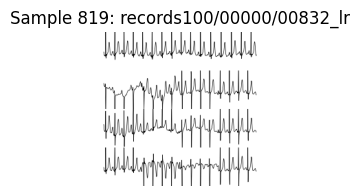

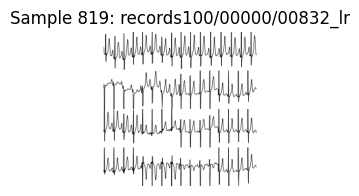

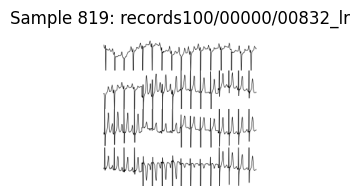

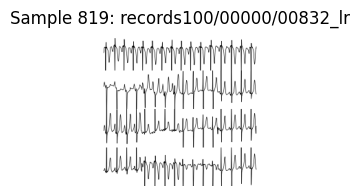

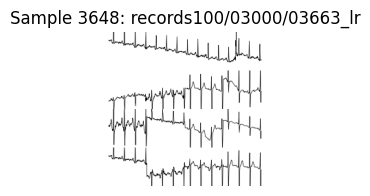

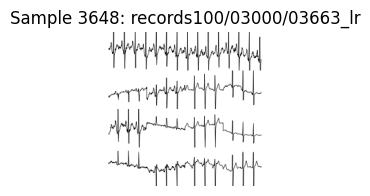

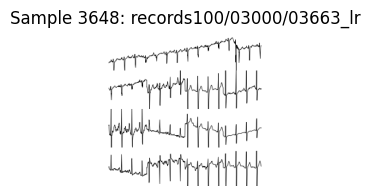

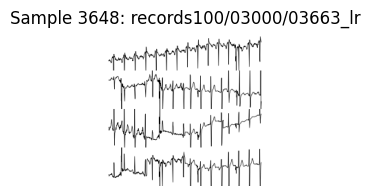

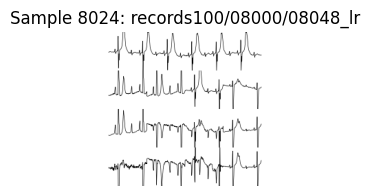

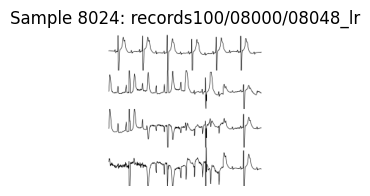

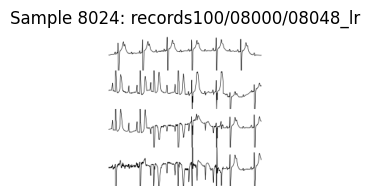

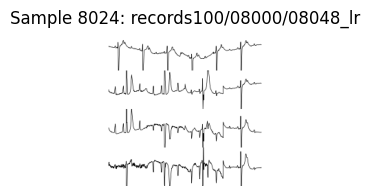

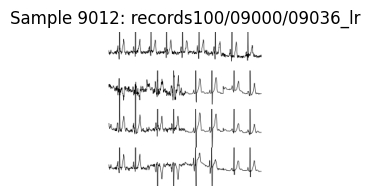

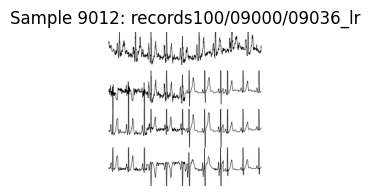

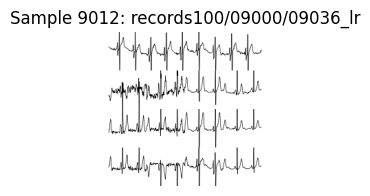

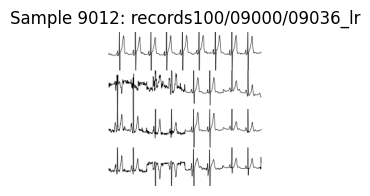

C:\Users\Wyatt\AppData\Local\Temp\ipykernel_23648\310612142.py:36: RuntimeWarning: invalid value encountered in true_divide
  lead: (twelve_leads_full[lead] - np.mean(twelve_leads_full[lead])) / np.std(twelve_leads_full[lead]) for lead in lead_names}
C:\Users\Wyatt\AppData\Local\Temp\ipykernel_23648\310612142.py:36: RuntimeWarning: invalid value encountered in true_divide
  lead: (twelve_leads_full[lead] - np.mean(twelve_leads_full[lead])) / np.std(twelve_leads_full[lead]) for lead in lead_names}
C:\Users\Wyatt\AppData\Local\Temp\ipykernel_23648\310612142.py:36: RuntimeWarning: invalid value encountered in true_divide
  lead: (twelve_leads_full[lead] - np.mean(twelve_leads_full[lead])) / np.std(twelve_leads_full[lead]) for lead in lead_names}
C:\Users\Wyatt\AppData\Local\Temp\ipykernel_23648\310612142.py:36: RuntimeWarning: invalid value encountered in true_divide
  lead: (twelve_leads_full[lead] - np.mean(twelve_leads_full[lead])) / np.std(twelve_leads_full[lead]) for lead in lead_nam

In [ ]:
SavePath = r'D:\ECGData\ECGImages229'

# Check and create the directory if it doesn't exist
if not os.path.exists(SavePath):
    os.makedirs(SavePath)
image_counter = processor.process_and_save_images(Y, SavePath)